In [25]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import seaborn as sns
from mab import MAB

In [26]:
params = [16, 256, 65536]

In [27]:
# Load data from file "./lists/output-100-16-???.txt" the ??? are seeds.
# every file is a list of 2 lists: [rewards, best_arms, value of first arm, value of second arm, value of third arm]
# best_arms is a list of the best arm at each timestep in one run
# rewards is a list of the reward at each timestep in one run
# value of first arm is the true value of the first arm
# value of second arm is the true value of the second arm
# value of third arm is the true value of the third arm
# We need to collect the rewards and best_arms in every file and average them
# use the regex to find the files "./lists/output-???-???-???.txt", ??? are numbers, and load them

def load_data(param):
    files = glob.glob("./lists/output-200-" + str(param) + "-???.txt")
    data = [0] * len(files)
    for i, file in enumerate(files):
        with open(file, "r") as f:
            data[i] = [int(x) for x in json.load(f)[0]]
    return data

In [28]:
data_16 = np.array(load_data(16))
data_256 = np.array(load_data(256))
data_65536 = np.array(load_data(65536))
data_16.shape

(90, 200)

In [29]:
average_16 = np.mean(data_16, axis=0)
average_256 = np.mean(data_256, axis=0)
average_65536 = np.mean(data_65536, axis=0)

In [30]:
# Normalize the data
average_16 = average_16 / params[0]
average_256 = average_256 / params[1]
average_65536 = average_65536 / params[2]

In [31]:
# calculate the cumulative average
cumulative_average_16 = np.cumsum(average_16) / np.arange(1, len(average_16) + 1)
cumulative_average_256 = np.cumsum(average_256) / np.arange(1, len(average_256) + 1)
cumulative_average_65536 = np.cumsum(average_65536) / np.arange(1, len(average_65536) + 1)

In [32]:
class UCBAgent:
    def __init__(self, num_actions=2, c=2):
        self.num_actions = num_actions
        self.c = c  # Exploration parameter

        # Initialize the action-value estimates and the count of action selections
        # Estimated value of actions
        self.Q = num_actions * [0]
        # Count of action selections, shound be initialized to 1/1000 to avoid division by 0, with the magnifier, it is 1
        self.N = num_actions * [1]

    def select_action(self):
        """
        Select an action for a given state using the UCB formula.
        """
        action = np.argmax([self.Q[a] + self.c * np.sqrt(np.log(sum(self.N)) / self.N[a]) for a in range(self.num_actions)])
        return action
    
    def update(self, action, reward):
        """
        Update the action-value estimates using the most recent action and reward.
        """
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def reset(self):
        """
        Reset the agent's parameters.
        """
        self.Q = self.num_actions * [0]
        self.N = self.num_actions * [1e-3]

In [33]:
# Create a 3-arm mab environment
mab = MAB()

# Create an agent
agent = UCBAgent(num_actions=3, c=2)

# Run the agent on the mab
# there are 1000 steps in each run
# run the agent 2000 times
steps = 200
run_times = 100

# initialize the average reward with a 2D array
average_reward = np.zeros((run_times, steps))

for i in range(run_times):
    rewards = []
    # reset the agent
    agent.reset()
    agent.update(0, mab.pull(0))
    agent.update(1, mab.pull(1))
    agent.update(2, mab.pull(2))
    for j in range(steps):
        action = agent.select_action()
        reward = mab.pull(action)
        agent.update(action, reward)
        rewards.append(reward)
    # calculate the cumulative average reward in this run
    average_reward[i] = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
    

# calculate the average cumulative average reward
average_reward = np.mean(average_reward, axis=0)

In [34]:
sns.set_theme()

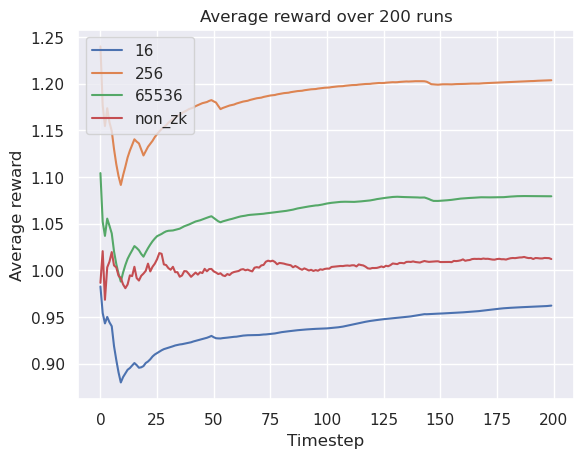

In [35]:
# plot the average rewards
plt.plot(cumulative_average_16, label="16")
plt.plot(cumulative_average_256, label="256")
plt.plot(cumulative_average_65536, label="65536")
plt.plot(average_reward, label="non_zk")
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Average reward")
plt.title("Average reward over 200 runs")
# plt.savefig("average_reward.png")
plt.show()

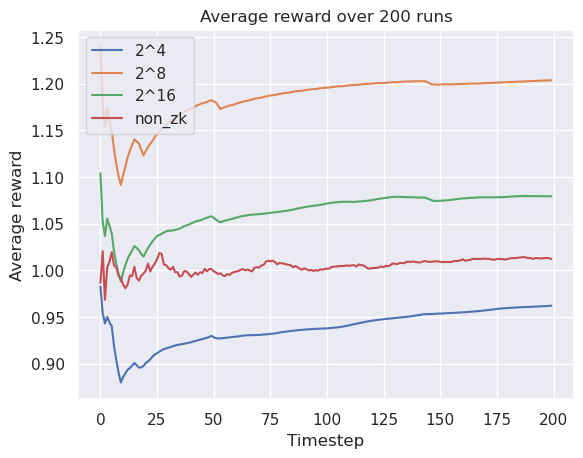

In [36]:
# use seaborn to plot the figure again
# plot the average rewards
sns.lineplot(data=cumulative_average_16, label="2^4")
sns.lineplot(data=cumulative_average_256, label="2^8")
sns.lineplot(data=cumulative_average_65536, label="2^16")
sns.lineplot(data=average_reward, label="non_zk")
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Average reward")
plt.title("Average reward over 200 runs")
plt.savefig("average_reward_seaborn.pdf", bbox_inches='tight')
plt.show()
